In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from pyproj import Transformer

## Determinación de los arrays de peso

In [2]:
## Apertura de shape de colonias y AGEBS
agebs=gpd.read_file('datos/09_ciudaddemexico/conjunto_de_datos/09a.shp')
agebs=agebs.to_crs('32614')
agebs['aAgebs']=agebs.geometry.area/10000 #unidades en hectáreas
colonias=gpd.read_file('datos/colonias_seduvi/colonias_seduvi.shp')
colonias.area=colonias.area/10000 #conversion de m2 a hectareas
# Cambio del indice para indexar posteriormente
colonias['index']=colonias.cve_col
colonias.set_index('index',inplace=True)
# Intesección espacial
inter=colonias.overlay(agebs,how="intersection",keep_geom_type=False)
inter['aInter']=inter.geometry.area/10000
# Calculo de porcentaje del área concidente de cada AGEB
inter["weight"]=inter.aInter/inter.aAgebs
#conteo de cuantos agebs coinciden en cada colonia
conteo=inter.groupby('cve_col').size()
# Identificación de cuales agebs por colonia
agebs_por_colonia=inter.groupby('cve_col')['CVEGEO'].apply(list)
w_por_colonia=inter.groupby('cve_col')['weight'].apply(list)

# Caso para la variable de población
En este ejercicio se procede a calcular la población a nivel colonia  partir de la población por AGEBs

In [3]:
# Apertura de datos  del censo
inputpath="datos/Censo de población vivienda/ageb_mza_urbana_09_cpv2020/conjunto_de_datos/conjunto_de_datos_ageb_urbana_09_cpv2020.csv"
datoscenso=pd.read_csv(inputpath,dtype={'ENTIDAD':str,'MUN':str,'LOC':str,'CVE_AGEB':str,'MZA':str})
datoscenso=datoscenso[datoscenso['NOM_LOC']=='Total AGEB urbana']
datoscenso=datoscenso.rename(columns={'AGEB':'CVE_AGEB'})
datoscenso["CVEGEO"]=datoscenso.ENTIDAD+datoscenso.MUN+datoscenso.LOC+datoscenso.CVE_AGEB
# Identificación de colonias únicas que si tiene alguna intersección
coloniasu=inter.cve_col.unique()
#Filtrado de estaciones que sí tiene intersección (solo se eliminan 2)
colonias=colonias[colonias['cve_col'].isin(coloniasu)]
colonias['pobW']=0
# HAY QUE OPTIMIZAR ESTA PART CON UN .LOC O ALGO ASÍ, o meterlo en una funció
for colonian,agebsn in agebs_por_colonia.items():
    colonias.loc[colonian,'pobW']=round(sum(datoscenso[datoscenso['CVEGEO'].isin(agebsn)]['POBTOT']*w_por_colonia[colonian]))
    

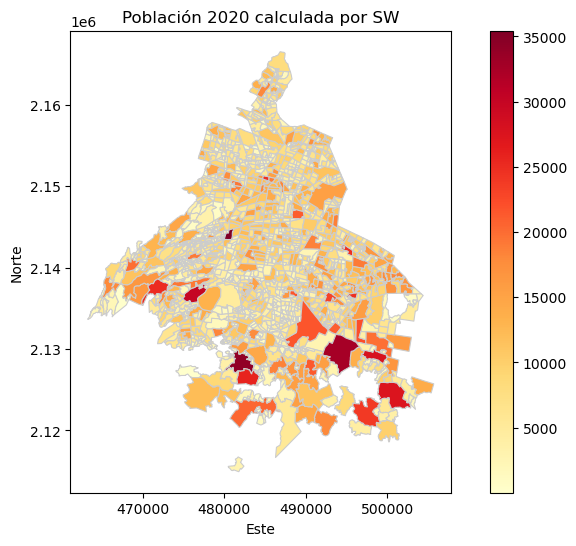

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
colonias.plot(column='pobW', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Población 2020 calculada por SW')
ax.set_xlabel('Este')
ax.set_ylabel('Norte')

# Mostrar el mapa coroplético
plt.show()